# Unsupervised exploration and Machine Learning

### Imports

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

### Dataset upload

**data_feature_x_new** - dataset we obtained after doing the feature selection in the preprocessing 

**data_feature_y** - dataset containing the class 'ec_lev'

In [5]:
data_feature_x = pd.read_csv('data_feature_x.csv')
data_feature_y = pd.read_csv('data_feature_y.csv')
data_new = pd.read_csv('data_new.csv')

Transformimg the dataset into an array.

In [6]:
data_feature_y = data_feature_y.to_numpy().flatten()

Spliting the dataset in train and test using the train_test_split function of the sklearn package. The division of the dataset was made using 70% for the training phase and 30% for the test phase, with a random_state of 32.

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_feature_x, data_feature_y, test_size = 0.3, random_state = 32)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382, 844) (9382,)
Test:  (4022, 844) (4022,)


# Unsupervised exploration

### Principal Component Analysis (PCA) and t-distributed Stochastic Neighbor Embedding (t-SNE)

**PCA** is an unsupervised Machine Learning Algorithm for Dimensionality Reduction. 
It does a linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
The reduction is carried out by creating components (set of observations correlated with each other), each component generated justifies a percentage of the variability of the data, which are ordered in descending order.

**t-SNE** is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In this step, these dimensionality reduction methods were performed on the dataset attributes and to understand how they relate to each other. The objective is to establish a relationship between the structural and physical-chemical features present in the datasets, through the methods of PCA and t-SNE, trying to verify if the developed components help in the classification of the subclasses.

We codified the subclasses by colors to pass to PCA and t-SNE.

In [ ]:
color_dic = {
    1:"g",
    3:"r",
    4:"c",
    5:"m",
    6:"y",
    7:"k",
    8:"w"
}

color_list = []

for classe in y_train:
    color_list += color_dic[classe]

We ploted the explained variance ratio by principal components.

Explained variance ratio by component:
[9.21907621e-01 7.79721183e-02 5.78164409e-05 2.24637622e-05
 1.01696111e-05 5.22994941e-06 4.15035699e-06 2.89349452e-06
 2.78336178e-06 2.25546261e-06]
First 2 PC: 99.98797395491782


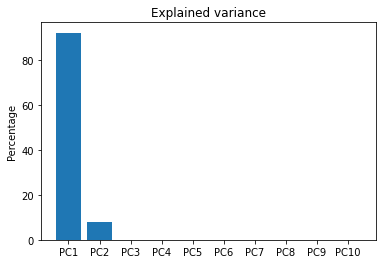

In [ ]:
from sklearn.decomposition import PCA

n = 10
principalComponents = PCA(n).fit(X_train)
print('Explained variance ratio by component:')
print(principalComponents.explained_variance_ratio_)  
print(f'First 2 PC: {sum(principalComponents.explained_variance_ratio_[0:2] * 100)}')

plt.bar(range(n), principalComponents.explained_variance_ratio_*100)
plt.xticks(range(n), ['PC'+str(i) for i in range(1, n+1)])
plt.title("Explained variance")
plt.ylabel("Percentage")
plt.show()

We can see that the first two principal components explain 99.99 % of the variance.

We performed the PCA in the data.

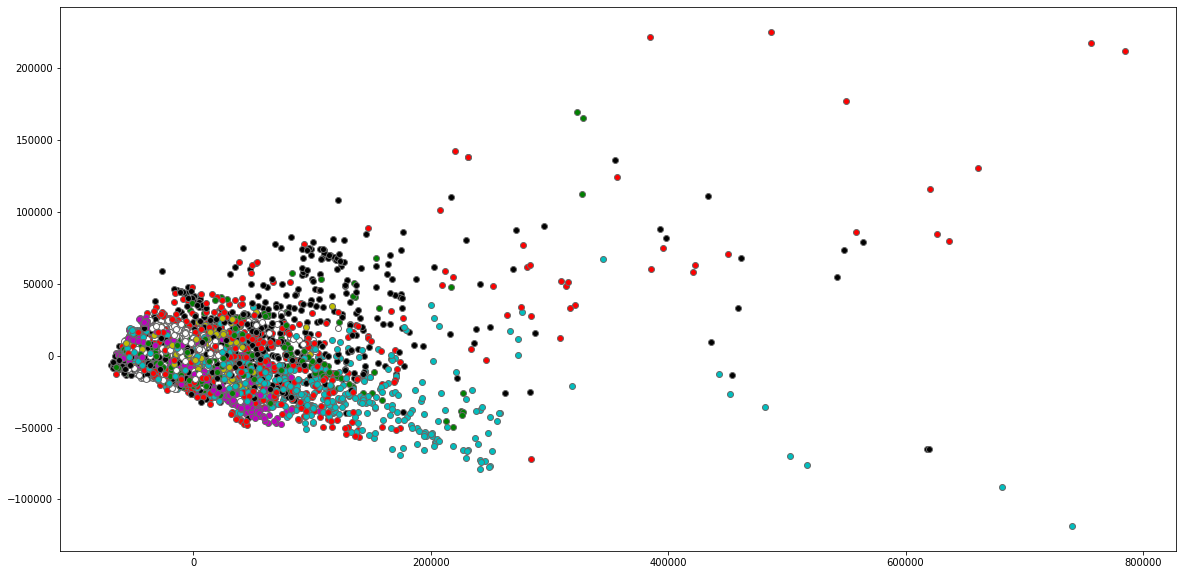

In [ ]:
colors = np.array(color_list)
principalComponents = PCA().fit_transform(X_train)
xs = principalComponents[:,0]
ys = principalComponents[:,1]

fig, axe = plt.subplots(figsize=(20,10))

for j in range(len(xs)): axe.plot(xs[j], ys[j], marker = "o", color = colors[j], markeredgecolor = "dimgrey")

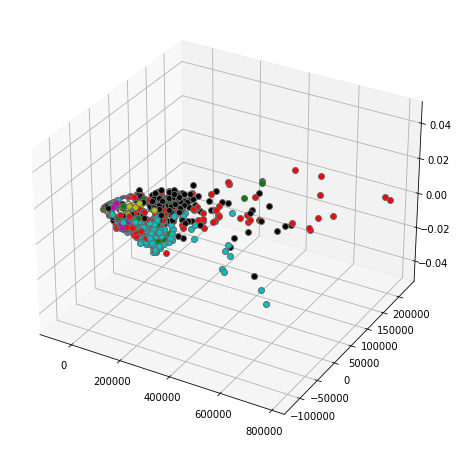

In [ ]:
fig = plt.figure(figsize=(10,8))
axe = fig.add_subplot(111, projection='3d')
for j in range(len(xs)): axe.plot(xs[j], ys[j], marker="o",color=colors[j], markeredgecolor="dimgrey")

In general, it is difficult to distinguish between the subclasses because they are clustered in the same region. Therefore, we can not take conclusions.

We performed the t-SNE in the data.

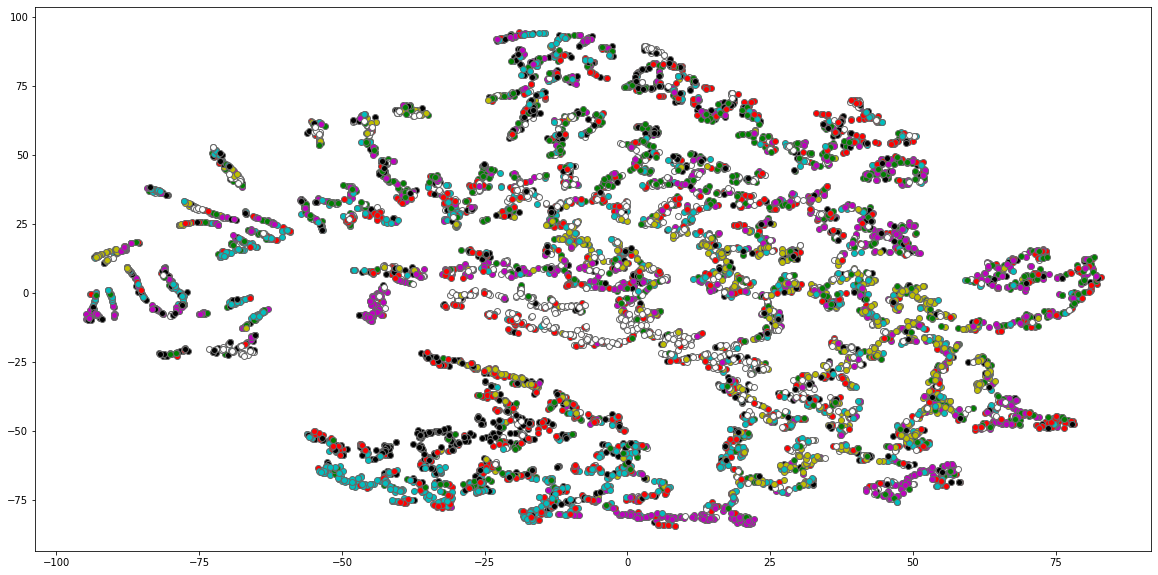

In [ ]:
from sklearn.manifold import TSNE

embeded = TSNE(n_components=2, n_iter=1000).fit_transform(X_train)

fig, axe = plt.subplots(figsize=(20, 10))
for j in range(len(embeded)): axe.plot(embeded[j, 0], embeded[j, 1], marker="o",color=colors[j], markeredgecolor="dimgrey")

In the t-SNE we can see more separation of the subclasses in relation to the PCA but is not enough to make conclusions about it.

###  k-means clustering

k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition N observations into k clusters. Each observation belongs to the cluster with the nearest mean (cluster centroid), serving as a cluster prototype.

We performed the k-means clustering in the data.
To choose the best number of clusters we ploted the distortion in function of the number of clusters.

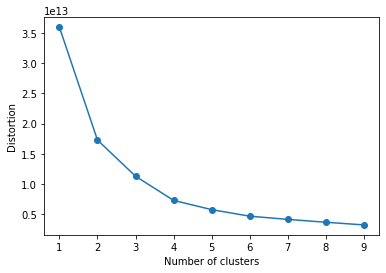

In [ ]:
from sklearn.cluster import KMeans

distortions = []
for i in range(1, 10):
    km = KMeans(
        n_clusters=i, init='k-means++',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X_train)
    distortions.append(km.inertia_)

plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

Analyzing the graph we chose 7 for the numbers of clusters.

In [ ]:
kmeans = KMeans(n_clusters = 7)
kmeans_y = kmeans.fit_predict(principalComponents)

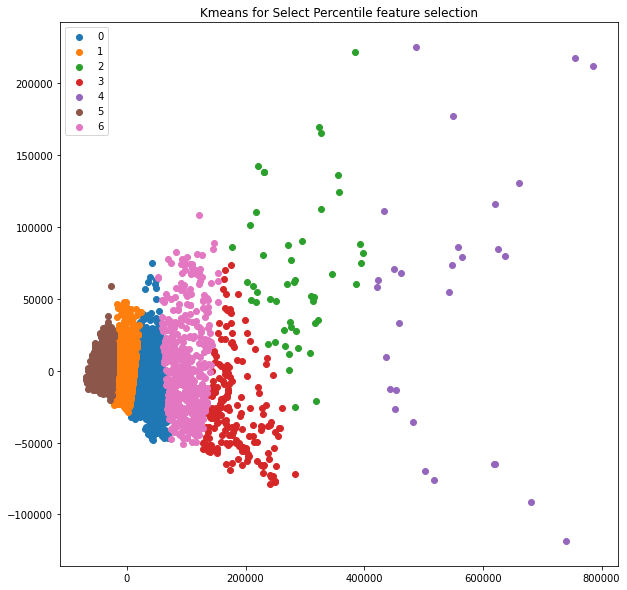

In [ ]:
u_labels = np.unique(kmeans_y)

plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(principalComponents[kmeans_y == i, 0], principalComponents[kmeans_y == i, 1], label=i)
    
plt.title('Kmeans for Select Percentile feature selection')
plt.legend()
plt.show()

Accordingly to the k-Means graph, there is a clear separation between the clusters. We can observe 7 groups with a few outliers.

# Machine Learning 

In this step we used the data from the multiclass classification dataframe to develop multiple models of machine learning (ML). The main goal of the criation of these models is to select the most adequate one for the prediction of the data we are studying.

We resorted to the linear_model class from the python package sklearn. This class will build prediction models for Random Forest, Support Vecto Machine (SVM), and k-nearest neighbors (KNN) for the data present in the different dataframes. The class init first needs to receive the data that will be used for the training step and the data that will be used for the model test. This division was performed using the sklearn **train_test_split** function. 

Given that the main objective throughout this step will be the prediction of multiclass classification, the machine learning models chosen for each classification were:

• **LogisticRegression** - "Logistic regression" is a Machine Learning classification algorithm that is used to predict the probability of certain classes based on some dependent variables. In short, the logistic regression model computes a sum of the input features (in most cases, there is a bias term), and calculates the logistic of the result. 

• **Random Forest** – Supervised Machine Learning model consisting of the construction of multiple decision trees, merging them in order to obtain a better and more stable forecast. This model is typically used for regression or classification problems.

• **SVM** - "Support Vector Machine" is a supervised machine learning model for regression and classification problems, and it is more usual to use this for classification problems, which consists of representing the data in an n-dimensional space where each value corresponds to a specific coordinate. The prediction is obtained from the best hyperplane found for significant differentiation of the different classes.

• **KNN** - "K-nearest neighbors" is a supervised machine learning model used for classification and regression problems, this model groups the data into the different K classifications depending on their proximity distance. This model is considered a "lazy learner algorithm" since the training set will not be immediately used, but stored, being only used when a new classification arises.

### Score_test function 

The following **score_test** function evaluates the model comparing the predicted values with the real values. The following metrics were used in this function:

• **accuracy** - evaluation metric that measures the number of correct predictions made by a model in relation to the total number of predictions made

• **MCC** -  measure of the quality of multiclass classification. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes

• **f1 score** - harmonic mean between precision and recall. It is used as a statistical measure to rate performance based on two factors (precision and recall for example)

• **confusion matrix** - matrix used to determine the performance of the classification models for a given set of test data 

• **false discovery rate** - controls the number of tests falsely declared significant as a proportion of the number of all tests declared significant

• **Sensitivity, hit rate, recall, or true positive rate** - ability of a classifier to find all positive instances. Explors the impact of feature changes on the model

• **Specificity or true negative rate** - recall of the negative instances. It is inversely proportional to the sensitivity

• **Classification Report** - summary of precision, recall, f1 score for all the seven classes

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.metrics import auc, roc_curve, matthews_corrcoef, f1_score, roc_auc_score, precision_recall_curve

def score_test(model, X_test, y_test):

    y_pred = model.predict(X_test)
    '''
    try:
        y_prob = model.predict_proba(X_test)
        
    except:
        y_prob = None'''
        
    print('Accuracy:', round(accuracy_score(y_test, y_pred), 4))
    print('\nMCC:', round(matthews_corrcoef(y_test, y_pred), 4))
    print('\nf1 score:', f1_score(y_test, y_pred, average = None)) 
    
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n')

    plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)
    plt.show()
    
    FP = (cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)).astype(float) # false positive
    FN = (cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)).astype(float) # false negative
    TP = (np.diag(cnf_matrix)).astype(float)                          # true positive
    TN = (cnf_matrix.sum() - (FP + FN + TP)).astype(float)            # true negative
    
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    
    # False discovery rate
    FDR = FP/(TP+FP)
    
    print('\nFalse discovery rate:\n', FDR)
    print('\nSensitivity, hit rate, recall, or true positive rate:\n', TPR)
    print('\nSpecificity or true negative rate:\n', TNR)
    
    y_pred = model.predict(X_test)
    print('\nClassification Report:\n', classification_report(y_test, y_pred))

#### ROC curve

**ROCAUC** (Receiver Operating Characteristic/Area Under the Curve) plot allows the user to visualize the tradeoff between the classifier’s sensitivity and specificity.

When plotted, the Receiver Operating Characteristic ROC curve displays the true positive rate on the Y axis and the false positive rate on the X axis on both a global average and per-class basis. The ideal point is therefore the top-left corner of the plot: false positives are zero and true positives are one.

In [9]:
from yellowbrick.classifier import ROCAUC

def plot_ROC_curve(model,X_train, X_test, y_train, y_test):

    visualizer = ROCAUC(model, encoder= {1:"1",
                                         3:"3",
                                         4:"4",
                                         5:"5",
                                         6:"6",
                                         7:"7",
                                         8:"8"})                  
                                      
    visualizer.fit(X_train, y_train)
    visualizer.score(X_test, y_test)
    visualizer.show()
    
    return visualizer

## Compare multiple models by cross-validation score

**CV score** -  The training set is split into k smaller sets. 
    For each of the k “folds”:
        A model is trained using  of the folds as training data;
        The resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive.

We utilized a **kfold** of 10 and used the **accuracy** function to compare the models.

In [10]:
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif

models = [('LR', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),  
          ('SVM', SVC())]


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    clf = make_pipeline(StandardScaler(), SelectPercentile(f_classif, percentile=30), model)
    cross_val = model_selection.cross_val_score(clf, data_feature_x, data_feature_y, cv=kfold, scoring='accuracy')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)

LR: 0.595044 SD:0.010883
RF: 0.779844 SD:0.011220
KNN: 0.704567 SD:0.010031
SVM: 0.744181 SD:0.012038


By observing the results, we can see that the RF and the SVM models obtained the best score among all the models tested.

#### Ploting of the cross-validation results

With the results obtained previously we made boxplots for each model to visualy compare the results and check any existent outliers.

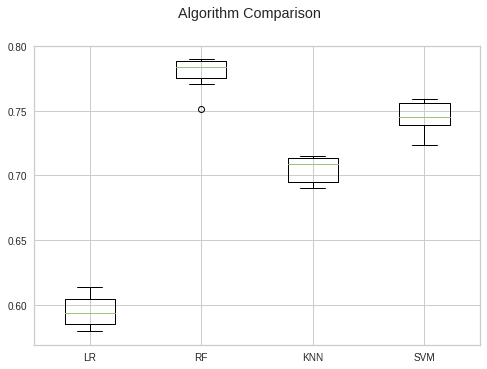

In [11]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

We observed that the RF model has 1 outlier.

## Optimize best models - RF and SVM with Grid-Search hyperparameter optimization 

In order to optimize the two best models obtained in cross-validation (**Random Forest** and **SVM**), we resorted to make a hyperparameter optimization using a method called **Grid-Search** implemented in sklearn. Grid-Searching consists of analyzing data to optimize the hyperparameters used in the development of machine learning models. This process can be computationally costly.

Since the **Grid-Search** process will build different models through cross-validation using only training data, for each possible combination of hyperparameters.

This model will eventually be evaluated by the test dataset, dataset with an input dataset never used in the GridSearch training process. The GridSearchCV function takes the following parameters:

• **SVC**  - used machine learning model (SVM)

• **param_grid** - dictionary that contains all of the parameters to try

    - C - penalty parameter of the error term. Tells the SVM optimization how much you want to avoid misclassifying each training example. For greater values of C, there is no way that SVM optimizer can misclassify any single point

    - kernel - it was only used the linear function because is the simplest kernel function and it is equivalent to not use any kernel function. In other words, it directly computes the scalar product between the inputs

    - gamma - gamma defines how much influence a single training example has. The larger gamma is, the closer other examples must be to be affected


• **cv** - number of cross-validation folds for each combination of parameters

• **refit** - true means that it trains on the entire training set after the cross validation is done

• **verbose** - represents the fold and candidate parameter indexes displayed together with the starting time of the computation

### Grid-Search for SVM model

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

sel_perc = SelectPercentile(f_classif, percentile=30)

clf = SVC()
CV_rfc = GridSearchCV(clf, 
                      param_grid={'C': [0.1,1,10,100,1000], 
                                  'kernel': ['rbf'], 
                                  'gamma': [1,0.1,0.01,0.001,0.0001]})

pipeline  = Pipeline([('scaler', StandardScaler()),
                      ('feature_sele', sel_perc),
                      ('clf_cv',CV_rfc)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('feature_sele', SelectPercentile(percentile=30)),
                ('clf_cv',
                 GridSearchCV(estimator=SVC(),
                              param_grid={'C': [0.1, 1, 10, 100, 1000],
                                          'gamma': [1, 0.1, 0.01, 0.001,
                                                    0.0001],
                                          'kernel': ['rbf']}))])

In [45]:
print(pipeline.steps[2][1].best_params_) 

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


The best parameter obtained with the GridSearchCV was 'C': 10, 'gamma': 0.01, 'kernel': 'rbf'.

#### Confusion matrix for Grid-Search results

Accuracy: 0.7877

MCC: 0.7523

f1 score: [0.70597484 0.75541299 0.7936772  0.78627968 0.90642616 0.69496021
 0.90582192]

Confusion Matrix:



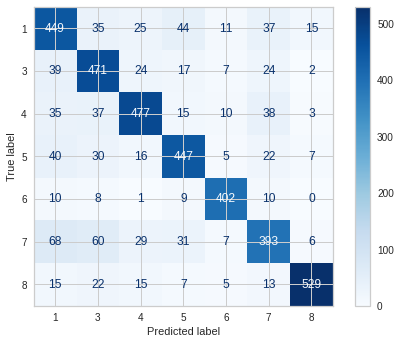


False discovery rate:
 [0.31554878 0.28959276 0.18739353 0.21578947 0.10067114 0.26815642
 0.05871886]

Sensitivity, hit rate, recall, or true positive rate:
 [0.7288961  0.80650685 0.77560976 0.78835979 0.91363636 0.66161616
 0.87293729]

Specificity or true negative rate:
 [0.9392249  0.94415358 0.96771353 0.96439942 0.98743719 0.957993
 0.99033958]

Classification Report:
               precision    recall  f1-score   support

           1       0.68      0.73      0.71       616
           3       0.71      0.81      0.76       584
           4       0.81      0.78      0.79       615
           5       0.78      0.79      0.79       567
           6       0.90      0.91      0.91       440
           7       0.73      0.66      0.69       594
           8       0.94      0.87      0.91       606

    accuracy                           0.79      4022
   macro avg       0.79      0.79      0.79      4022
weighted avg       0.79      0.79      0.79      4022



In [13]:
score_test(pipeline, X_test, y_test)

For the new model we obtained an accuracy of 0.7877 and a MCC of 0.7523.

#### ROC curve of the SVM model

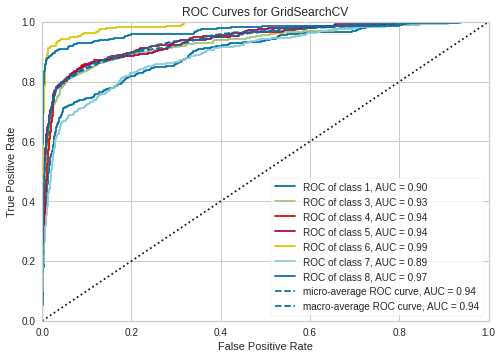

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1707788cd0>,
       encoder={1: '1', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'},
       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                 ('feature_sele',
                                  SelectPercentile(percentile=30)),
                                 ('clf_cv',
                                  GridSearchCV(estimator=SVC(),
                                               param_grid={'C': [0.1, 1, 10,
                                                                 100, 1000],
                                                           'gamma': [1, 0.1,
                                                                     0.01,
                                                                     0.001,
                                                                     0.0001],
                                                           'kernel': ['rbf']}))]))

In [14]:
plot_ROC_curve(pipeline, X_train, X_test, y_train, y_test)

The class with the most true positive values is the class 6 because it has the higher value of the y axis compared with the others. It has an AUC of 0.99.

#### Feature importance of the SVM model

Extract the best estimator from grid search.

In [129]:
best_estimator = pipeline.steps[2][1].best_estimator_

Get the feature importances by using the coef_ attribute.

In [130]:
importances = np.abs(best_estimator.dual_coef_)
importances

array([[1.93396302, 0.39210377, 1.29558989, ..., 0.57091342, 0.83324783,
        1.31359837],
       [1.92919142, 0.0366056 , 1.87300518, ..., 1.22440178, 0.15565717,
        0.30265912],
       [0.        , 0.24829694, 0.68982959, ..., 0.65137733, 0.09246355,
        0.        ],
       [0.        , 0.        , 0.72729878, ..., 0.27096926, 0.27083802,
        0.22505149],
       [2.83901772, 0.48668822, 0.39914878, ..., 0.20863821, 0.        ,
        0.        ],
       [2.27534487, 0.        , 0.06705351, ..., 0.39639341, 0.90254529,
        0.        ]])

In [131]:
importances = importances / importances.sum()

Sort the importances in descending order and print the indices of the top k features.

In [139]:
k = 10
top_k_indices = importances.argsort()[::-1][:k]
print(f"Top {k} feature indices: {top_k_indices}")

Top 10 feature indices: [[8143 2278 5399 ... 4736 7532 7803]
 [8143 5912 2046 ... 2501 3640 5429]
 [   0 5341 5331 ... 2501 4646 1335]
 [   0 3636 3639 ... 6994 5429 6276]
 [2586 5764 5763 ... 3613 2532  659]
 [2216 1401 3214 ... 2532  822 2231]]


### Grid-Search for Random Forest model

In this step, we made another **Grid-Search** but this time the machine learning model used was the **Random Forest**. 

Also we changed the parametrs in **param_grid** used in the **GridSearchCV**.
Whether **bootstrap** samples are used when building trees. If False, the whole dataset is used to build each tree.
The **max_depth** is the maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
The **n_estimators** is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower.

In [16]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

sel_perc = SelectPercentile(f_classif, percentile=30)
clf = RandomForestClassifier() 
CV_rfc = GridSearchCV(clf, 
                      param_grid={"bootstrap": [True, False],
                                  "max_depth": [10, 100, None],
                                  "n_estimators": [200, 1000, 2000]},
                                  cv= 3, scoring = 'accuracy')

pipeline_rf  = Pipeline([('scaler', StandardScaler()),
                      ('feature_sele',sel_perc),
                      ('clf_cv',CV_rfc)])

pipeline_rf.fit(X_train, y_train)
pipeline_rf.predict(X_test)

array([4, 6, 4, ..., 7, 5, 3])

In [46]:
print(pipeline_rf.steps[2][1].best_params_) 

{'bootstrap': False, 'max_depth': None, 'n_estimators': 1000}


The best parameter obtained with the **GridSearchCV** was 'bootstrap': False, 'max_depth': None, 'n_estimators': 1000

#### Confusion matrix for Grid-Search results

We then procided to make another confusion matrix for the new model obtained with the **GridSearchCV** function.

Accuracy: 0.7939

MCC: 0.7595

f1 score: [0.7365129  0.7416309  0.79967294 0.82568807 0.86909871 0.70598439
 0.8968386 ]

Confusion Matrix:



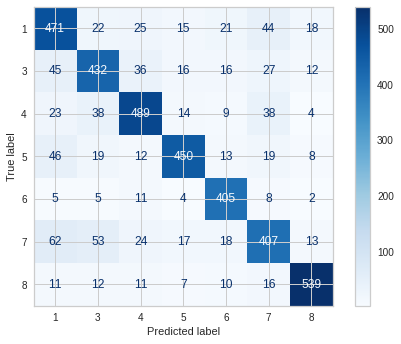


False discovery rate:
 [0.28959276 0.25645439 0.19572368 0.13957935 0.17682927 0.27191413
 0.09563758]

Sensitivity, hit rate, recall, or true positive rate:
 [0.76461039 0.73972603 0.79512195 0.79365079 0.92045455 0.68518519
 0.88943894]

Specificity or true negative rate:
 [0.94362889 0.95666085 0.96507191 0.9788712  0.97571189 0.95565928
 0.98331382]

Classification Report:
               precision    recall  f1-score   support

           1       0.71      0.76      0.74       616
           3       0.74      0.74      0.74       584
           4       0.80      0.80      0.80       615
           5       0.86      0.79      0.83       567
           6       0.82      0.92      0.87       440
           7       0.73      0.69      0.71       594
           8       0.90      0.89      0.90       606

    accuracy                           0.79      4022
   macro avg       0.80      0.80      0.80      4022
weighted avg       0.79      0.79      0.79      4022



In [17]:
score_test(pipeline_rf, X_test, y_test)

For the new model we obtained an accuracy of 0.7939 and a MCC of 0.7595.

#### ROC curve of the Random Forest model

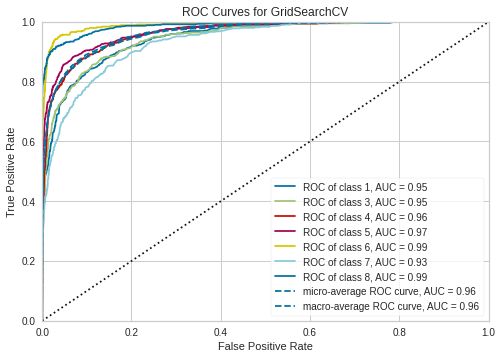

ROCAUC(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f1707844d00>,
       encoder={1: '1', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8'},
       estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                 ('feature_sele',
                                  SelectPercentile(percentile=30)),
                                 ('clf_cv',
                                  GridSearchCV(cv=3,
                                               estimator=RandomForestClassifier(),
                                               param_grid={'bootstrap': [True,
                                                                         False],
                                                           'max_depth': [10,
                                                                         100,
                                                                         None],
                                                           'n_estimators': [200,
              

In [18]:
plot_ROC_curve(pipeline_rf, X_train, X_test, y_train, y_test)

The classes with the most true positive values are the class 6 and 8 because they have the higher values of the y axis compared with the others. They have an AUC of 0.99.

#### Feature importance of the Random Forest model

We try to understand which feature contribute the most for our Random Forest model.

Extract the best estimator from grid search.

In [142]:
best_estimator = pipeline_rf.steps[2][1].best_estimator_

Get the feature importances by using the 'feature_importances_' attribute.

In [143]:
importances = best_estimator.feature_importances_

Get the feature_names.

In [106]:
feature_names = data_feature_x.columns

 Plot the feature importances as a bar chart.

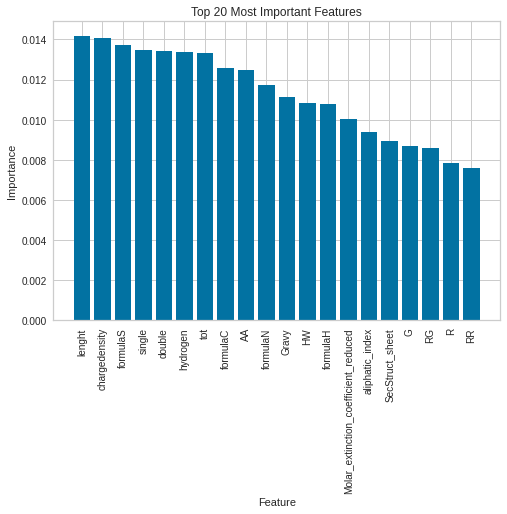

In [110]:
sorted_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

top_20_features = sorted_importances[:20]
x = [x[0] for x in top_20_features]
y = [x[1] for x in top_20_features]

plt.bar(x, y)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 20 Most Important Features')
plt.xticks(rotation=90)
plt.show()

The three most influencial features are: lenght, chargedensity and formulaS.

## Conclusions

By doing a cross-validation of our four models, Logistic Regression, Random Forest, KNN and SVM, we concluded that the two with the best score are the Random Forest model with 0.779844 and SVM model with a score of 0.744181. After doing the Grid_search to discover the best hyperparameters for each model, we then fitted the model and checked the metrics and the feature importance. 

For the SVM model we obtained an accuracy of 0.7877 and a MCC of 0.7523.  For the Random Forest model we obtained an accuracy of 0.7939 and a MCC of 0.7595. 

Comparing the two models accuracy's and MCC we can observe that the Random Forest had the better results. 

# Machine Learning - PFAM

Dataset division in x and y.

In [21]:
data_new_y = data_new['ec_lev']
data_new_x = data_new.drop(['sequence','ec_lev'], axis=1)
print(f'y dimension: {data_new_y.shape}')
print(f'X dimension: {data_new_x.shape}')

y dimension: (13404,)
X dimension: (13404, 9)


Transformimg the dataset into an array.

In [22]:
fam = data_new['pfam']  
fam

0        PF00128;PF02806;PF02922;
1                        PF00581;
2                        PF01040;
3                        PF00464;
4                PF14572;PF13793;
                   ...           
13399                    PF02390;
13400                    PF00201;
13401                    PF05690;
13402                    PF00464;
13403            PF06968;PF04055;
Name: pfam, Length: 13404, dtype: object

In [23]:
from sklearn.preprocessing._label import MultiLabelBinarizer

fam = [i.split(';') for i in data_new['pfam']] 
fam = [list(filter(None, x)) for x in fam]  

mlb = MultiLabelBinarizer()
fam_ho = mlb.fit_transform(fam)
classes = mlb.classes_
print(classes)
print('number classes', len(classes))
print(fam_ho.shape)
print(fam_ho)

['PF00009' 'PF00010' 'PF00013' ... 'PF18706' 'PF18755' 'PF18836']
number classes 1141
(13404, 1141)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
from sklearn.preprocessing import MultiLabelBinarizer
y=data_new['ec_lev'].astype(str)

mlb = MultiLabelBinarizer()
y_new = mlb.fit_transform(y)
print(mlb.classes_)
print(y_new)

['1' '3' '4' '5' '6' '7' '8']
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


Train and test split. 

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(fam_ho, y_new, test_size = 0.3, random_state = 32, stratify = y)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (9382, 1141) (9382, 7)
Test:  (4022, 1141) (4022, 7)


#### Compare models by cross-validation score

In [26]:
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


models = [('RF', RandomForestClassifier()),
        ('KNN', KNeighborsClassifier())] 


names = []
results = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)

    cross_val = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cross_val)
    names.append(name)
    msg = "%s: %f SD:%f" % (name, cross_val.mean(), cross_val.std())
    print(msg)

RF: 0.959817 SD:0.003716
KNN: 0.936475 SD:0.005347


The model with the best score was the Random Forest model.

### Ploting of the cross-validation results

With the results obtained previously we made boxplots for each model to visualy compare the results and check any existent outliers.

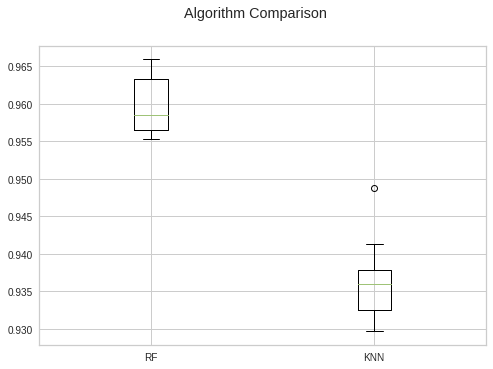

In [27]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

The KNN model has 1 outliers.

#### Grid-Search for Random Forest

We performed the grid search only for the random forest model since it shows the best accuracy.

In [30]:
from sklearn.model_selection import GridSearchCV

param_grid = {"bootstrap": [True, False],
              "max_depth": [10, 100, None],
              "n_estimators": [200, 1000, 2000]} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, cv = 3, refit = True, verbose = 3, scoring = 'accuracy') 

grid.fit(X_train, y_train)
print(grid.best_params_) 

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END bootstrap=True, max_depth=10, n_estimators=200;, score=0.051 total time=   3.8s
[CV 2/3] END bootstrap=True, max_depth=10, n_estimators=200;, score=0.048 total time=   3.8s
[CV 3/3] END bootstrap=True, max_depth=10, n_estimators=200;, score=0.070 total time=   3.9s
[CV 1/3] END bootstrap=True, max_depth=10, n_estimators=1000;, score=0.074 total time=  19.2s
[CV 2/3] END bootstrap=True, max_depth=10, n_estimators=1000;, score=0.072 total time=  18.6s
[CV 3/3] END bootstrap=True, max_depth=10, n_estimators=1000;, score=0.036 total time=  18.7s
[CV 1/3] END bootstrap=True, max_depth=10, n_estimators=2000;, score=0.074 total time=  36.8s
[CV 2/3] END bootstrap=True, max_depth=10, n_estimators=2000;, score=0.069 total time=  36.8s
[CV 3/3] END bootstrap=True, max_depth=10, n_estimators=2000;, score=0.036 total time=  37.3s
[CV 1/3] END bootstrap=True, max_depth=100, n_estimators=200;, score=0.741 total time=  10.5s
[C

The best parameter obtained with the GridSearchCV was 'bootstrap' = False, 'max_depth' = None, 'n_estimators' = 1000.

#### Scoring function

In [32]:
from sklearn.metrics import accuracy_score, f1_score, log_loss, matthews_corrcoef, confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

def score_test_bin(model=None, x_test=None, y_test=None):
    scores = {}
      
    y_prob = model.predict(x_test)
    y_pred= np.argmax(y_prob,axis=1)
    y_test=np.argmax(y_test, axis=1)
    
    scores['Accuracy'] = accuracy_score(y_test, y_pred)
    scores['MCC'] = matthews_corrcoef(y_test, y_pred)
    scores['log_loss'] = log_loss(y_test, y_prob)

    
    scores['f1 score weighted'] = f1_score(y_test, y_pred, average = 'weighted')
    y_test_reshape = y_test.reshape(y_test.shape[0])  
    scores['precision'] = precision_score(y_test, y_pred, average = 'weighted')
    scores['recall'] = recall_score(y_test, y_pred, average = 'weighted')

    cm = confusion_matrix(y_test, y_pred)

    plot_confusion_matrix(cm, cmap=plt.cm.Blues)
    plt.show()
    
    return scores

#### Confusion Matrix for the random forest model

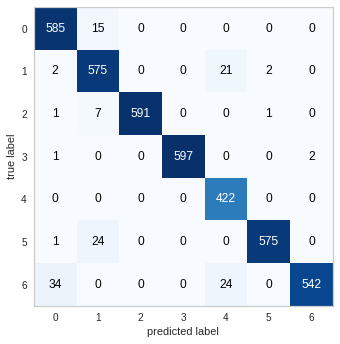

{'Accuracy': 0.9664346096469418,
 'MCC': 0.9610205931293578,
 'log_loss': 0.8615290922676841,
 'f1 score weighted': 0.9665616959233155,
 'precision': 0.9681928579781786,
 'recall': 0.9664346096469418}

In [33]:
score_test_bin(grid, X_test, y_test)

For the new model we obtained an accuracy of 96,64% and a MCC of 0.9610.

#### Feature importance of the random forest model

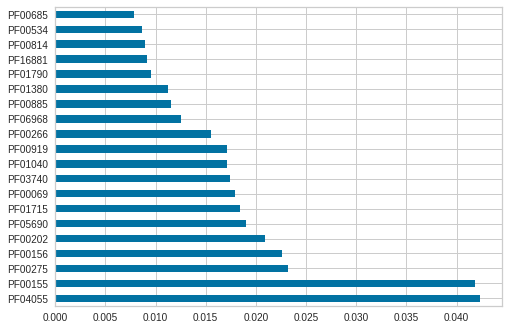

In [47]:
pd.Series(abs(grid.best_estimator_.feature_importances_), index=classes).nlargest(20).plot(kind='barh')

The two most influencial classes are: PF00155 and PF04055.

## Conclusions

By doing a cross-validation of two four models, Random Forest and KNN, we concluded that the Random Forest model obtained the best score with a score of 96,00%. After doing the Grid_search to descover the best hyperparameters for each model, we then fitted the model and checked the metrics and the feature importance. After that, we obtained an accuracy of 96,64% and a MCC of 0.9610. The two most influencial classes obtained were: PF00155 and PF04055. 